<a id='top'></a>

# NLP 1: Predict Fresh Movies w/Word Frequency & TF-IDF Bag-of-Words 

#### --> Natural Language Processing Methods in this Project:

 - Word frequency approach to vector encoding for bag-of-words modeling
 - Term Frequency - Inverse Document Frequency approach to vector encoding for bag-of-words modeling

#### --> Natural Language Processing Tools in this Project:

 - Scikit-Learn

Natural Language Processing is a major tributary of data science. For this project I used NLP methods to create features derived from text to predict a categorical target. Specically, this NLP project entailed:

 - preprocessing text so that it can be used for machine learning algorithms;
 - comparing two vector encoding approaches (word frequency and Term Frequency-Inverse Document Frequency) to extract features from movie reviews for bag-of-words modeling for predicting fresh reviews.  
 
Rottentomatoes.com is a movie review aggregator that classifies positive movie reviews as "Fresh," and negative movie reviews as "Rotten." Along with this categorical designation, for many of the reviews the data includes snippets of the text movie reviews. These snippets are the natural language text (the features) that will be used to predict whether the review is classified as Fresh or Rotten (the target).


- [Step 1](#Step_1) Preprocessing. Keep only fresh/rotten data for which there are also text reviews. Create a dataframe tallying number of reviews for each reviewer, and what percentage of their reviews were "fresh." 
- [Step 2](#Step_2) Exploratory data analysis. Here I looked at the distribution of reviewers by the percentage of fresh ratings that they awarded. Histograms revealed that many reviewers awarded 0% or 100% fresh ratings. With these reviewers removed from the data, the percentage of fresh reviews per reviewer was close to normally distributed. After the EDA, I modified the dataframe to only include reviewers with 15 or more reviews.
- [Step 3](#Step_3) Creating features (vectors) based on word frequency. A frequency vector is the frequency of each word as it appears in the document. I used Scikit-Learn's CountVectorizer to create features that are sparse arrays representing the document ID and the the counts of the different words in the documents. Using CountVectorizer, the text is also tokenized (broken into components) and normalized (different permutations of words are consolidated). 
- [Step 4](#Step_4) Use word frequency vectors to predict Fresh reviews. With vectors created from this bag-of-words approach, I used several machine learning algorithms to predict Fresh reviews based on the text of the reviews.
- [Step 5](#Step_5) Creating features (vectors) based on Term Frequency–Inverse Document Frequency. Word frequency vectors do not account for frequency of words in the overall corpus (the collection of documents that are being compared). The Term Frequency–Inverse Document Frequency approach does; it normalizes words in a document relative to the total corpus. Here I used Scikit-Learn's TfidfVectorizer to create features that are word counts normalized by the inverse document frequency.
- [Step 6](#Step_6) Use TF-IDF vectors to predict Fresh reviews. I used the Term Frequency–Inverse Document Frequency vectors and several machine learning algorithms for a bag-of-words approach to predicting Fresh reviews.
- [Step 7](#Step_7) Conclusion and references. 

In [1]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('max_columns', 120)
pd.set_option('max_colwidth', 5000)
pd.options.display.max_rows = 999
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Back to [top](#top) 

<a id='Step_1'></a>

#### Step 1: Preprocessing
Keep only fresh/rotten data for which there are also text reviews. Create a dataframe tallying number of reviews for each reviewer, and what percentage of their reviews were "fresh." 

In [2]:
file_loc = "C:/Users/rmbrm/Documents/DS_WP/data/critics.csv"
df = pd.read_csv(file_loc, index_col=None, na_values=['NA'], usecols = ['critic', 'fresh', 'quote', 'rtid'] )
df = df[~df.quote.isnull()]
df.head()

,critic,fresh,quote,rtid
1,Derek Adams,fresh,"So ingenious in concept, design and execution that you could watch it on a postage stamp-sized screen and still be engulfed by its charm.",9559
2,Richard Corliss,fresh,The year's most inventive comedy.,9559
3,David Ansen,fresh,A winning animated feature that has something for everyone on the age spectrum.,9559
4,Leonard Klady,fresh,The film sports a provocative and appealing story that's every bit the equal of this technical achievement.,9559
5,Jonathan Rosenbaum,fresh,"An entertaining computer-generated, hyperrealist animation feature (1995) that's also in effect a toy catalog.",9559


In [3]:
n_reviews = len(df)
n_movies = df.rtid.unique().size
n_critics = df.critic.unique().size
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()
means = grp.fresh.mean()
reviewers = pd.concat([counts, means], axis=1)
reviewers.rename(columns={'critic': 'Number of Reviews'}, inplace=True)
reviewers['fresh']= (reviewers['fresh']*100)
reviewers = reviewers.round()
reviewers['fresh']=reviewers['fresh'].astype('Int64')
reviewers.rename(columns={'fresh': 'Percent of Reviews Fresh'}, inplace=True)
reviewers.head()

,Number of Reviews,Percent of Reviews Fresh
critic,,
A.D. Murphy,13,100
A.H. Weiler,17,71
A.O. Scott,19,37
Aaron Hillis,2,100
Abel Green,5,100


Back to [top](#top) 

<a id='Step_2'></a>

#### Step 2: Exploratory data analysis

Here I looked at the distribution of reviewers by the percentage of fresh ratings that they awarded. The first histogram, with all the data, shows many reviewers awarded 0% or 100% fresh ratings. I interpreted this as indicating a large number of reviewers rated very few movies (so all or none of their reviews are fresh), OR, a large number of reviewers are not discriminating.

For the second histogram, I only plotted reviewers with more than 15 reviews("Prolific Reviewers"). This distribution was much closer to a normal distribution. I assume this data is cleaner, so I'll use it for the analysis. After the EDA, I modified the dataframe to only include reviewers with 15 or more reviews.

In [4]:
prolific = reviewers[reviewers['Number of Reviews'] > 15]  
prolific=prolific.drop(['Number of Reviews'], axis=1)
reviewers=reviewers.drop(['Number of Reviews'], axis=1)

Text(0, 0.5, 'Number of Reviewers')

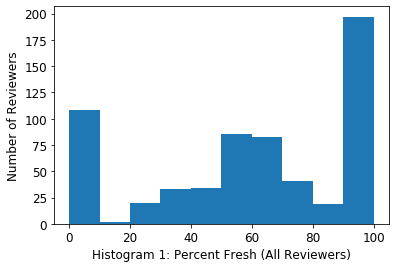

In [5]:
reviewers['Percent of Reviews Fresh'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Histogram 1: Percent Fresh (All Reviewers)", fontsize=12)
plt.ylabel("Number of Reviewers",fontsize=12)

Text(0, 0.5, 'Number of Reviewers')

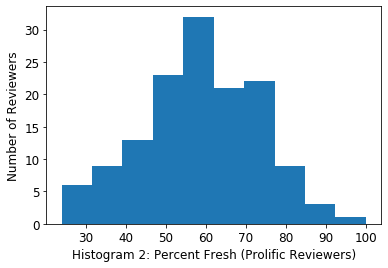

In [6]:
prolific['Percent of Reviews Fresh'].hist(bins=10, grid=False, xlabelsize=12, ylabelsize=12)
plt.xlabel("Histogram 2: Percent Fresh (Prolific Reviewers)", fontsize=12)
plt.ylabel("Number of Reviewers",fontsize=12)

In [7]:
# Edit dataframe so it only includes reviewers who have many reviews
many_reviews = prolific.index.tolist() 
df = df.loc[df['critic'].isin(many_reviews)]

Back to [top](#top) 

<a id='Step_3'></a>

#### Step 3: Creating features (vectors) based on word frequency

A frequency vector is the frequency of each word as it appears in the document. Here I used Scikit-Learn's CountVectorizer to create features that are sparse arrays representing the document ID and the the counts of the different words in the documents. Using CountVectorizer, the text is also tokenized (broken into components) and normalized (different 
permutations of words are consolidated).

In [8]:
# Text preprocessing for NLP - remove upper case letters and punctuation
df['quote'] = df['quote'].str.lower()
df['quote'] = df['quote'].str.replace("\d+", "")

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

corpus = df['quote']
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(corpus)

y = df.fresh.values.astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

Back to [top](#top) 

<a id='Step_4'></a>

#### Step 4: Use word frequency vectors to predict Fresh reviews
I used the word frequency vectors and several machine learning algorithms for a bag-of-words approach to predicting Fresh reviews.

In [10]:
from sklearn import model_selection
from sklearn import metrics
from statistics import mean

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

models = []
models.append(('Linear Regression', LogisticRegression()))
models.append(('Stochastic Gradient Descent', SGDClassifier()))
models.append(('Naive Bayes', MultinomialNB()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
models.append(('K-Nearest Neighbors', KNeighborsClassifier()))

results = []
names = []
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    clf_results = metrics.accuracy_score(y_test, pred)
    results.append(clf_results)
    names.append(name)
    msg = "%s: %.2f" % (name, clf_results)
    print(msg)

print('\n')
overall = mean(results)
print("Average accuracy for word frequency approach: {:.2f}".format(overall))

Linear Regression: 0.77
Stochastic Gradient Descent: 0.75
Naive Bayes: 0.77
Random Forest: 0.68
Gradient Boosting Classifier: 0.67
K-Nearest Neighbors: 0.63


Average accuracy for word frequency approach: 0.71


Back to [top](#top) 

<a id='Step_5'></a>

#### Step 5: Creating features (vectors) based on Term Frequency–Inverse Document Frequency 

Word frequency vectors do not account for frequency of words in the overall corpus (the collection of documents that are being compared). The Term Frequency–Inverse Document Frequency approach does; it normalizes words in a document relative to the total corpus. Here I used Scikit-Learn's TfidfVectorizer to create features that are word counts normalized by the inverse document frequency. 

In [12]:
# TF-IDF Vectorizing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

corpus = df['quote']
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(corpus)

y = df.fresh.values.astype(np.int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=53)

<a id='Step_6'></a>

Back to [top](#top) 

#### Step 6: Use TF-IDF vectors to predict Fresh reviews
I used the Term Frequency–Inverse Document Frequency vectors and several machine learning algorithms for a bag-of-words approach to predicting Fresh reviews.

In [13]:
models = []
models.append(('Linear Regression', LogisticRegression()))
models.append(('Stochastic Gradient Descent', SGDClassifier()))
models.append(('Naive Bayes', MultinomialNB()))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Gradient Boosting Classifier', GradientBoostingClassifier()))
models.append(('K-Nearest Neighbors', KNeighborsClassifier()))

In [14]:
results = []
names = []
#scoring = 'metrics.accuracy_score(y_test, pred)'
for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    clf_results = metrics.accuracy_score(y_test, pred)
    results.append(clf_results)
    names.append(name)
    msg = "%s: %.2f" % (name, clf_results)
    print(msg)

print('\n')
overall = mean(results)
print("Average accuracy for TF-IDF approach: {:.2f}".format(overall))

Linear Regression: 0.75
Stochastic Gradient Descent: 0.77
Naive Bayes: 0.69
Random Forest: 0.67
Gradient Boosting Classifier: 0.67
K-Nearest Neighbors: 0.70


Average accuracy for TF-IDF approach: 0.71


Back to [top](#top) 

<a id='Step_7'></a>

#### Step 7: Results and references

Two different methods were used to create features from text: word frequency and Term Frequency-Inverse Document Frequency. Using these bag-of-words approaches and comparing several machine learning algorithms revealed small differences in the predictive accuracy of individual algorithms.

However, the average predictive accuracy of the machine learning algorithms was the same, whether the document vectors were created using word frequency or TF-IDF bag-of-word approaches. I attribute this to the fact that the "reviews" in the Rottentomatoes data are actually very short excerpts of the actual movie reviews. For this reason, I believe they don't contain a lot of data to be used to differentiate between fresh and rotten reviews. Nonetheless, this project provides a template to be used for natural language processing for making categorical predictions. 

The primary references for this project are:

 - Bengfort, Benjamin; Bilbro, Rebecca; Ojeda, Tony. Applied Text Analysis with Python: Enabling Language-Aware Data Products with Machine Learning.
 - Schütze, Hinrich; Raghavan, Prabhakar; Manning, Christopher D. Introduction to Information Retrieval.